In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
%matplotlib inline
import matplotlib.pyplot as plt
!pip install Keras-Preprocessing
!pip install keras==2.12.0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
train_bodies = pd.read_csv(('/content/train_bodies.csv'))
# train_bodies.head()
train_stance = pd.read_csv(('/content/train_stances.csv'))

In [ ]:
from tqdm.notebook import tqdm
count=0
for i in tqdm(range(train_stance.shape[0])):
    for j in range(train_bodies.shape[0]):
        if train_bodies.loc[j,'Body ID']==train_stance.loc[i,'Body ID']:
            train_stance.loc[i,'articleBody'] = train_bodies.loc[j,'articleBody']


train_stance.to_csv('/content/data_combined.csv',index=False)

# Specify the file path in your Google Drive
file_path = '/content/data_combined.csv'

# Load the data from the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the data
df.head()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [ ]:
encode_cat = {"Stance":{"['unrelated']": 0, "['agree']": 1, "['disagree']": 2,"['discuss']": 3}}
y_df = df.replace(encode_cat)
y = y_df['Stance']
y.value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

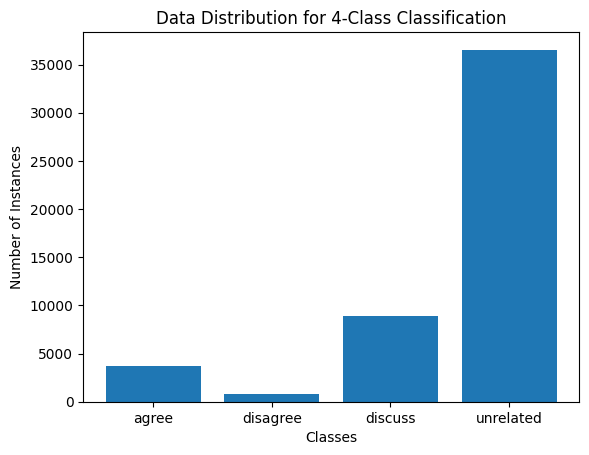

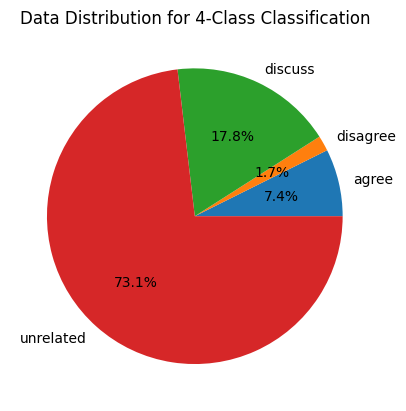

In [ ]:


# Example data distribution
data_distribution = {'agree': 3678, 'disagree': 840, 'discuss': 8909, 'unrelated': 36545}

# Create a bar chart
plt.bar(data_distribution.keys(), data_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of Instances')
plt.title('Data Distribution for 4-Class Classification')
plt.show()

# Create a pie chart
plt.pie(data_distribution.values(), labels=data_distribution.keys(), autopct='%1.1f%%')
plt.title('Data Distribution for 4-Class Classification')
plt.show()


In [ ]:
# text length
df['Headline_length'] = df['Headline'].apply(len)
df['articleBody_length'] = df['articleBody'].apply(len)
df.head()

,Headline,Body ID,Stance,articleBody,Headline_length,articleBody_length
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...,115,1093
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...,65,2584
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...,91,1111
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...,82,500
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's...",63,3386


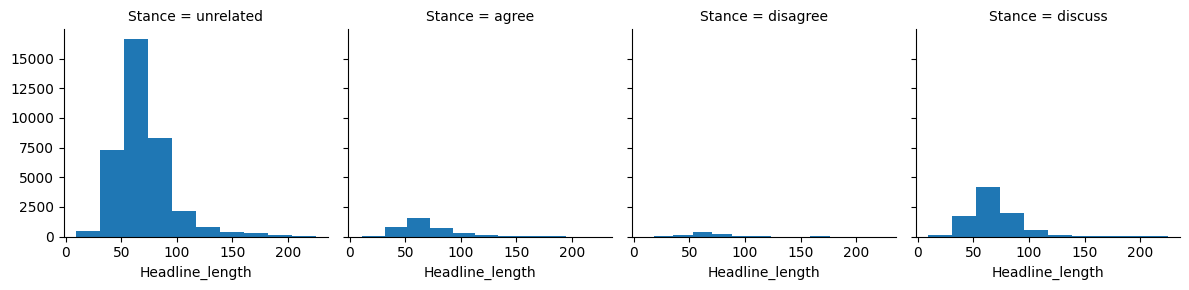

In [ ]:
g = sns.FacetGrid(df,col='Stance')
g.map(plt.hist,'Headline_length')

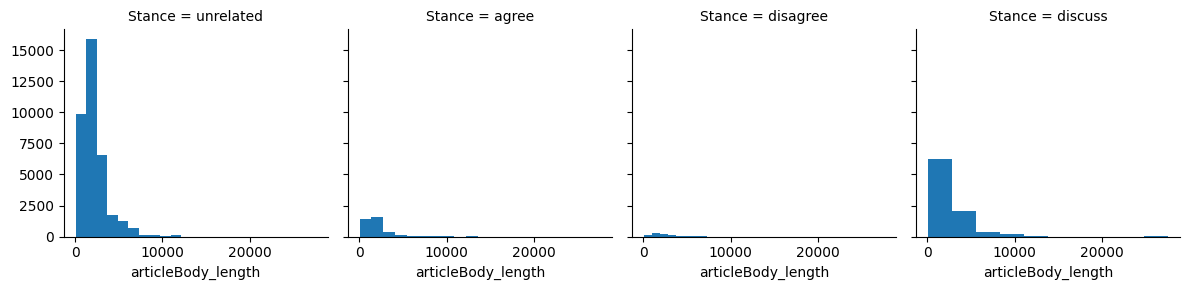

In [ ]:
g = sns.FacetGrid(df,col='Stance')
g.map(plt.hist,'articleBody_length')

In [ ]:
df['concatenated_column'] = df['Headline'].astype(str) + df['articleBody'].astype(str)

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

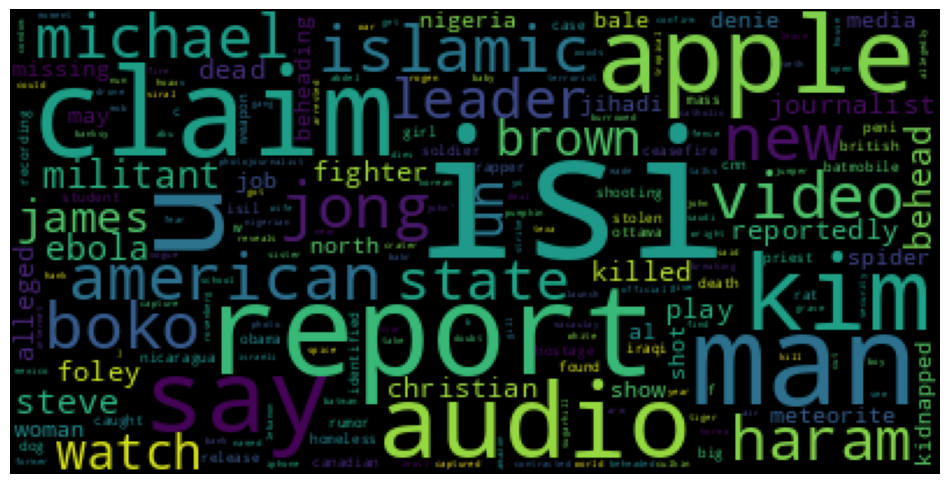

In [ ]:
from wordcloud import WordCloud
def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s
df['clean_concatenated_column'] = df['concatenated_column'].apply(clean_text)

text = df['concatenated_column'].to_string().lower()
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [ ]:
X=df['clean_concatenated_column']
y=df['Stance']
X

0        Police find mass graves with at least '15 bodi...
1        Hundreds of Palestinians flee floods in Gaza a...
2        Christian Bale passes on role of Steve Jobs, a...
3        HBO and Apple in Talks for $15/Month Apple TV ...
4        Spider burrowed through tourist's stomach and ...
                               ...                        
49967    Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...
49968    Brian Williams slams social media for speculat...
49969    Mexico Says Missing Students Not Found In Firs...
49970    US Lawmaker: Ten ISIS Fighters Have Been Appre...
49971    Shots Heard In Alleged Brown Shooting Recordin...
Name: clean_concatenated_column, Length: 49972, dtype: object

In [ ]:
X.shape

(49972,)

In [ ]:
y.shape

(49972,)

In [ ]:
vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 80  # Max number of words kept at the end of each text

In [ ]:
from keras.preprocessing.text import Tokenizer

from keras_preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)

    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self

    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))

sequencer = TextsToSequences(num_words=vocab_size)

In [ ]:
sequencer

TextsToSequences()

In [ ]:
class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length.
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros

    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None

    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self

    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.wrappers.scikit_learn import KerasClassifier
batch_size = 128
max_features = vocab_size + 1

import tensorflow as tf
tf.random.set_seed(seed)


# Define your model creation function with additional Dense layers
def create_model(max_features):
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    # Add more Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
def model_evaluate():

    print('Test Accuracy:\t{:0.1f}%'.format(accuracy_score(y_test,y_preds)*100))

    #classification report
    print('\n')
    print(classification_report(y_test, y_preds))

    #confusion matrix
    confmat = confusion_matrix(y_test, y_preds)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

<ipython-input-26-f8b7a0ef9c6c>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=10, batch_size=batch_size,


TRAIN: [12493 12494 12495 ... 49969 49970 49971] TEST: [    0     1     2 ... 12490 12491 12492]
TRAIN: [    0     1     2 ... 49969 49970 49971] TEST: [12493 12494 12495 ... 24983 24984 24985]
TRAIN: [    0     1     2 ... 49969 49970 49971] TEST: [24986 24987 24988 ... 37476 37477 37478]
TRAIN: [    0     1     2 ... 37476 37477 37478] TEST: [37479 37480 37481 ... 49969 49970 49971]
(37479,) (12493,) (37479,) (12493,)


<ipython-input-21-f99b2c4cf85b>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.texts_to_sequences(texts))


Epoch 1/10
293/293 [==============================] - 359s 1s/step - loss: 0.6738 - accuracy: 0.7627
Epoch 2/10
293/293 [==============================] - 350s 1s/step - loss: 0.5178 - accuracy: 0.8096
Epoch 3/10
293/293 [==============================] - 348s 1s/step - loss: 0.4896 - accuracy: 0.8152
Epoch 4/10
293/293 [==============================] - 351s 1s/step - loss: 0.4704 - accuracy: 0.8199
Epoch 5/10
293/293 [==============================] - 346s 1s/step - loss: 0.4602 - accuracy: 0.8217
Epoch 6/10
293/293 [==============================] - 349s 1s/step - loss: 0.4522 - accuracy: 0.8247
Epoch 7/10
293/293 [==============================] - 347s 1s/step - loss: 0.4463 - accuracy: 0.8270
Epoch 8/10
293/293 [==============================] - 360s 1s/step - loss: 0.4432 - accuracy: 0.8275
Epoch 9/10
293/293 [==============================] - 347s 1s/step - loss: 0.4396 - accuracy: 0.8282
Epoch 10/10
293/293 [==============================] - 348s 1s/step - loss: 0.4363 - accura

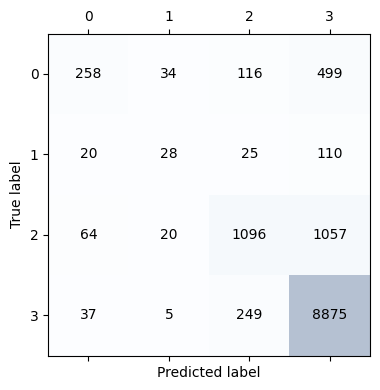

In [ ]:
# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=10, batch_size=batch_size,
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)
#k-folds
kf = KFold(n_splits=4)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

pipeline.fit(X_train, y_train);
print('Computing predictions on test set...')

y_preds = pipeline.predict(X_test)
model_evaluate()

In [ ]:
# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=batch_size,
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)
#k-folds
kf = KFold(n_splits=8)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

pipeline.fit(X_train, y_train);
print('Computing predictions on test set...')

y_preds = pipeline.predict(X_test)
model_evaluate()

<ipython-input-37-aae9b39bbe75>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=batch_size,


TRAIN: [ 6247  6248  6249 ... 49969 49970 49971] TEST: [   0    1    2 ... 6244 6245 6246]
TRAIN: [    0     1     2 ... 49969 49970 49971] TEST: [ 6247  6248  6249 ... 12491 12492 12493]
TRAIN: [    0     1     2 ... 49969 49970 49971] TEST: [12494 12495 12496 ... 18738 18739 18740]
TRAIN: [    0     1     2 ... 49969 49970 49971] TEST: [18741 18742 18743 ... 24985 24986 24987]
TRAIN: [    0     1     2 ... 49969 49970 49971] TEST: [24988 24989 24990 ... 31231 31232 31233]
TRAIN: [    0     1     2 ... 49969 49970 49971] TEST: [31234 31235 31236 ... 37477 37478 37479]
TRAIN: [    0     1     2 ... 49969 49970 49971] TEST: [37480 37481 37482 ... 43723 43724 43725]
TRAIN: [    0     1     2 ... 43723 43724 43725] TEST: [43726 43727 43728 ... 49969 49970 49971]
(43726,) (6246,) (43726,) (6246,)


<ipython-input-21-f99b2c4cf85b>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.texts_to_sequences(texts))


Epoch 1/2
342/342 [==============================] - 412s 1s/step - loss: 0.6678 - accuracy: 0.7679
Epoch 2/2
342/342 [==============================] - 407s 1s/step - loss: 0.5105 - accuracy: 0.8110


In [ ]:
# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=batch_size,
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)
#k-folds
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

pipeline.fit(X_train, y_train);
print('Computing predictions on test set...')

y_preds = pipeline.predict(X_test)
model_evaluate()

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming you have already created your Keras model using create_model
model = create_model(max_features)

# Generate a visualization of the model and save it to a file
plot_model(model, to_file='model_flowchart.png', show_shapes=True, show_layer_names=True)
